In [17]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import koreanize_matplotlib
warnings.filterwarnings('ignore')
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
import matplotlib
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 데이터 분할, 의사결정나무, 랜덤포레스트 모델
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
# 그래디언트 부스팅
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
# 분류 SVM
from sklearn.svm import SVC
# 분류 NN (MPLClassifier)
from sklearn.neural_network import MLPClassifier
# 평가 함수
from sklearn.metrics import accuracy_score

# confusion matrix
from sklearn.metrics import confusion_matrix
# 분류모델 평가함수
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import plot_tree

- 데이터 스키마
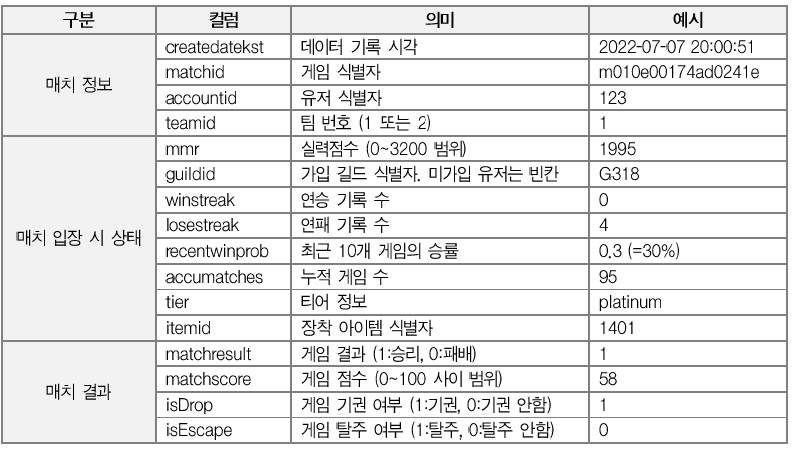

### 매치데이터 호출

In [3]:
data = pd.read_csv('match_data.csv')

### 데이터 형태, 기술통계, 결측값 확인

In [4]:
display(data.head())
display(data.shape)
display(data.info())
display(data.describe())
display(data.isnull().sum())

print("""데이터는 약 41만개의 행과 16개의 변수로 이루어져 있다.
범주형 변수로는(데이터 기록 시각 제외) matchid, guildid, tier가 있으며 나머지는 수치형 데이터로 구성되어 있다.
수치형 변수에서 accountid, itemid의 경우 guildid와 같은 고유 식별값에 해당하므로 범주형 변수로 인식한다.
guildid 컬럼에 약 23만개의 결측값이 존재하는데 이는 길드 미가입 유저를 의미하므로 이후에 0 또는 없음으로 구분한다.""")

,createdatekst,matchid,accountid,teamid,mmr,guildid,winstreak,losestreak,recentwinprob,accumatches,tier,itemid,matchresult,matchscore,isDrop,isEscape
0,2022-07-04 00:27:58,m00160017353d8e81,2097311063,1,1812,G69102,1,0,0.428571,7,gold,1364,0,25,1,0
1,2022-07-04 00:27:58,m00160017353d8e81,1560653129,1,1868,NaN,1,0,0.333333,9,gold,1178,0,35,0,0
2,2022-07-04 00:27:58,m00160017353d8e81,872694401,1,1809,G5900,0,2,0.200000,162,platinum,1385,0,39,0,0
3,2022-07-04 00:27:58,m00160017353d8e81,84538717,1,1631,G424,2,0,0.300000,11,bronze,1338,0,0,1,0
4,2022-07-04 00:27:58,m00160017353d8e81,142829,2,1973,NaN,0,3,0.500000,412,platinum,1277,1,41,0,0


(410384, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410384 entries, 0 to 410383
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   createdatekst  410384 non-null  object 
 1   matchid        410384 non-null  object 
 2   accountid      410384 non-null  int64  
 3   teamid         410384 non-null  int64  
 4   mmr            410384 non-null  int64  
 5   guildid        177427 non-null  object 
 6   winstreak      410384 non-null  int64  
 7   losestreak     410384 non-null  int64  
 8   recentwinprob  410384 non-null  float64
 9   accumatches    410384 non-null  int64  
 10  tier           410384 non-null  object 
 11  itemid         410384 non-null  int64  
 12  matchresult    410384 non-null  int64  
 13  matchscore     410384 non-null  int64  
 14  isDrop         410384 non-null  int64  
 15  isEscape       410384 non-null  int64  
dtypes: float64(1), int64(11), object(4)
memory usage: 50.1+ MB


None

,accountid,teamid,mmr,winstreak,losestreak,recentwinprob,accumatches,itemid,matchresult,matchscore,isDrop,isEscape
count,4.103840e+05,410384.000000,410384.000000,410384.000000,410384.000000,410384.000000,410384.000000,410384.000000,410384.000000,410384.000000,410384.000000,410384.000000
mean,1.057482e+09,1.500000,2017.942880,1.009745,1.003704,0.494668,392.355920,1367.779124,0.500000,55.028186,0.211521,0.013785
std,6.157916e+08,0.500001,246.652163,1.446266,1.464491,0.179296,568.547598,67.623264,0.500001,25.717702,0.408388,0.116596
min,1.351900e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,5.207713e+08,1.000000,1922.000000,0.000000,0.000000,0.400000,44.000000,1360.000000,0.000000,41.000000,0.000000,0.000000
50%,1.040999e+09,1.500000,2013.000000,0.000000,0.000000,0.500000,163.000000,1387.000000,0.500000,61.000000,0.000000,0.000000
75%,1.577797e+09,2.000000,2133.000000,2.000000,1.000000,0.600000,508.000000,1401.000000,1.000000,76.000000,0.000000,0.000000
max,2.131598e+09,2.000000,3173.000000,29.000000,29.000000,1.000000,4126.000000,1416.000000,1.000000,100.000000,1.000000,1.000000


createdatekst         0
matchid               0
accountid             0
teamid                0
mmr                   0
guildid          232957
winstreak             0
losestreak            0
recentwinprob         0
accumatches           0
tier                  0
itemid                0
matchresult           0
matchscore            0
isDrop                0
isEscape              0
dtype: int64

데이터는 약 41만개의 행과 16개의 변수로 이루어져 있다.
범주형 변수로는(데이터 기록 시각 제외) matchid, guildid, tier가 있으며 나머지는 수치형 데이터로 구성되어 있다.
수치형 변수에서 accountid, itemid의 경우 guildid와 같은 고유 식별값에 해당하므로 범주형 변수로 인식한다.
guildid 컬럼에 약 23만개의 결측값이 존재하는데 이는 길드 미가입 유저를 의미하므로 이후에 0 또는 없음으로 구분한다.


### 결측값 대치

In [5]:
# 로우데이터 복사
df = data.copy()

# accountid, itemid 컬럼 형태 변환
df['accountid'] = df['accountid'].astype('object')
df['itemid'] = df['itemid'].astype('object')

# guildid 컬럼 결측치 대치
df['guildid'].fillna('없음', inplace=True)

# 결측치 대치 후 데이터셋 확인
df.isnull().sum()

createdatekst    0
matchid          0
accountid        0
teamid           0
mmr              0
guildid          0
winstreak        0
losestreak       0
recentwinprob    0
accumatches      0
tier             0
itemid           0
matchresult      0
matchscore       0
isDrop           0
isEscape         0
dtype: int64

### 데이터 EDA

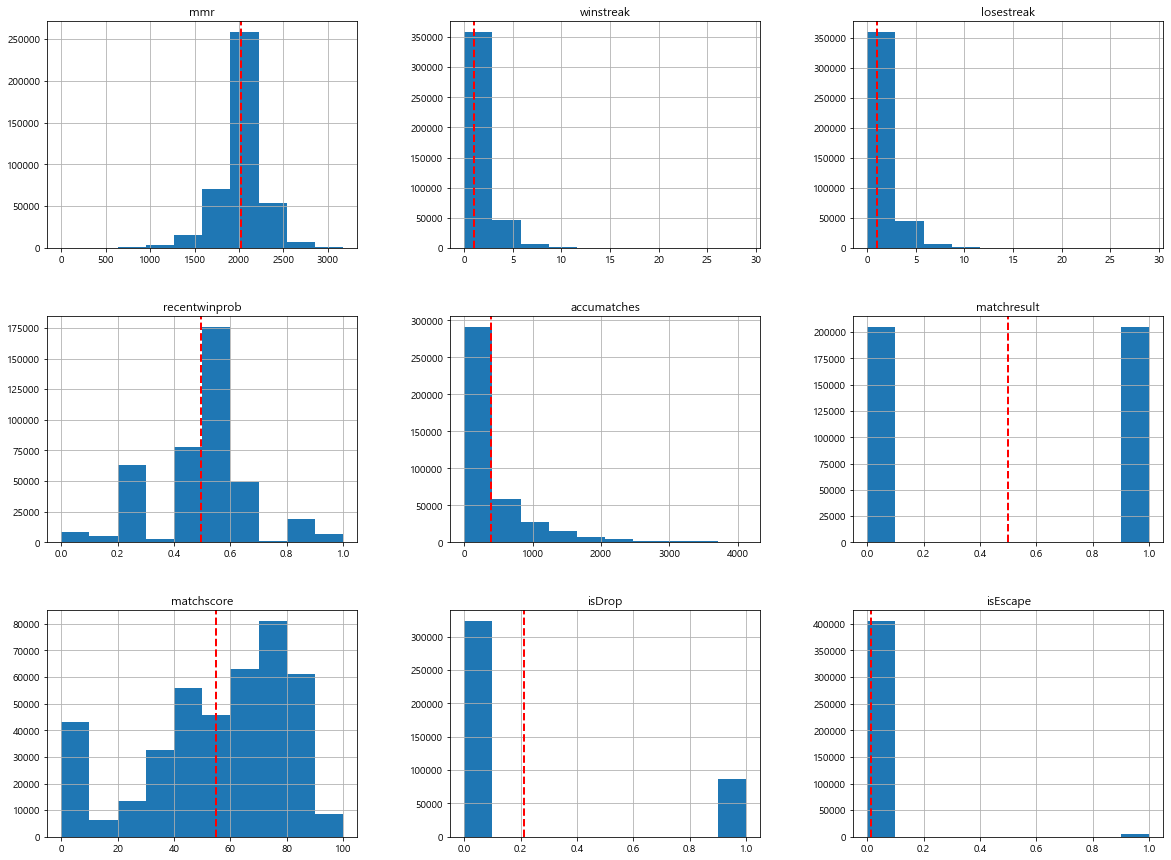

먼저 범주형, 수치형 변수를 구분하여 변수들의 데이터 시각화를 수행하였다.
수치형 변수의 경우 히스토그램을 통해 전반적인 분포를 파악하였다. 각 수치형 변수들에 대한 인사이트는 다음과 같다.
--------------------------------------------------------------------------------------------------------------------
- mmr은 1900 ~ 2300 사이가 많았다. mmr은 실력을 나타내는 가장 핵심 지표로, 이에 따른 승패 여부가 확연할 것으로 예상된다.
- winstreak, losestreak은 0인 경우가 가장 많았으며 대부분 0~5 사이에 있다. 연승 혹은 연패가 매우 심한 경우 어뷰징 등을 의심해 볼 수 있다.
- recentwinprob은 0.5 부근에 가장 많이 분포한다. 최근 10게임에 대한 승률이므로 연승, 연패과 매우 큰 연관성을 가질 것으로 예상된다.
- accumatches는 0~5 사이에 가장 많이 분포하고 있다. 입문자인 경우가 많거나, 스토리 콘텐츠 등 대전 이외의 게임 요소가 존재할 수도 있다.
- matchscore는 40~90점 사이에 고르게 분포되어 있다. 0점인 경우가 꽤 많은데, 추후 자세히 살펴볼 필요가 있을 것 같다.
- isDrop에서 기권을 한 경우(1)는 약 8.7만, isEscape에서 탈주를 한 경우(1)는 약 5.6천으로 탈주는 전체 데이터 대비 약 1% 정도이다.



In [6]:
obj_df = df.select_dtypes('object').drop(columns=['createdatekst'])
num_df = df.select_dtypes(include=['float', 'int64']).drop(columns=['teamid'])

ax = num_df.hist(figsize=(20,15))
for variable, subplot in zip(num_df.columns, ax.ravel()):
    subplot.axvline(num_df[variable].mean(), color='r', linestyle='dashed', linewidth=2)
plt.show()
print("""먼저 범주형, 수치형 변수를 구분하여 변수들의 데이터 시각화를 수행하였다.
수치형 변수의 경우 히스토그램을 통해 전반적인 분포를 파악하였다. 각 수치형 변수들에 대한 인사이트는 다음과 같다.
--------------------------------------------------------------------------------------------------------------------
- mmr은 1900 ~ 2300 사이가 많았다. mmr은 실력을 나타내는 가장 핵심 지표로, 이에 따른 승패 여부가 확연할 것으로 예상된다.
- winstreak, losestreak은 0인 경우가 가장 많았으며 대부분 0~5 사이에 있다. 연승 혹은 연패가 매우 심한 경우 어뷰징 등을 의심해 볼 수 있다.
- recentwinprob은 0.5 부근에 가장 많이 분포한다. 최근 10게임에 대한 승률이므로 연승, 연패과 매우 큰 연관성을 가질 것으로 예상된다.
- accumatches는 0~5 사이에 가장 많이 분포하고 있다. 입문자인 경우가 많거나, 스토리 콘텐츠 등 대전 이외의 게임 요소가 존재할 수도 있다.
- matchscore는 40~90점 사이에 고르게 분포되어 있다. 0점인 경우가 꽤 많은데, 추후 자세히 살펴볼 필요가 있을 것 같다.
- isDrop에서 기권을 한 경우(1)는 약 8.7만, isEscape에서 탈주를 한 경우(1)는 약 5.6천으로 탈주는 전체 데이터 대비 약 1% 정도이다.
""")

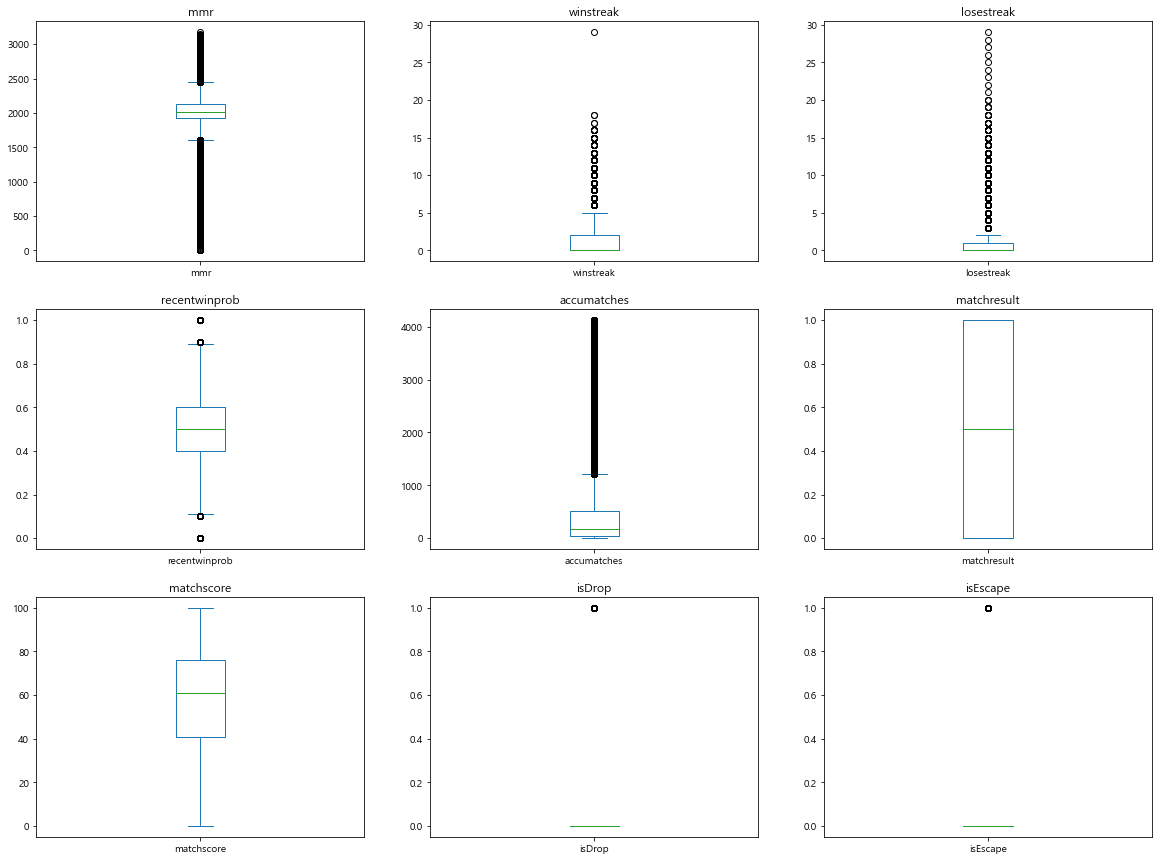

수치형 변수에 대한 상자플롯 결과는 위와 같다. matchresult, matchscore를 제외한 모든 변수에서 이상값이 존재하며 
mmr, winstreak, losestreak, accumatches 변수의 경우 매우 많은 이상값이 확인되었다.
mmr, accumatches의 경우 실력이 높거나(혹은 반대) 게임을 오래한 유저라면 중앙값과 확연한 차이가 날 수 있다.
또한, 두 변수의 경우 매치 결과에 큰 영향을 미치는 변수일 수 있으므로 상관관계를 확인한 후 처리 방법을 결정하도록 한다.
* winstreak, losestreak, recentwinprob 변수의 경우 어뷰징, 대리 등의 요소가 존재할 수 있으므로 IQR을 이용해 이상값을 대체한다.


In [7]:
# 서브플롯 생성을 위한 행, 열 개수 정의
num_rows = 3
num_cols = 3

# 서브플롯 생성
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
axes = axes.ravel()

for i, col in enumerate(num_df.columns):
    num_df[col].plot(kind='box', ax=axes[i])
    axes[i].set_title(col)  # Set the title for the subplot
    
plt.show()

print("""수치형 변수에 대한 상자플롯 결과는 위와 같다. matchresult, matchscore를 제외한 모든 변수에서 이상값이 존재하며 
mmr, winstreak, losestreak, accumatches 변수의 경우 매우 많은 이상값이 확인되었다.
mmr, accumatches의 경우 실력이 높거나(혹은 반대) 게임을 오래한 유저라면 중앙값과 확연한 차이가 날 수 있다.
또한, 두 변수의 경우 매치 결과에 큰 영향을 미치는 변수일 수 있으므로 상관관계를 확인한 후 처리 방법을 결정하도록 한다.
* winstreak, losestreak, recentwinprob 변수의 경우 어뷰징, 대리 등의 요소가 존재할 수 있으므로 IQR을 이용해 이상값을 대체한다.""" )

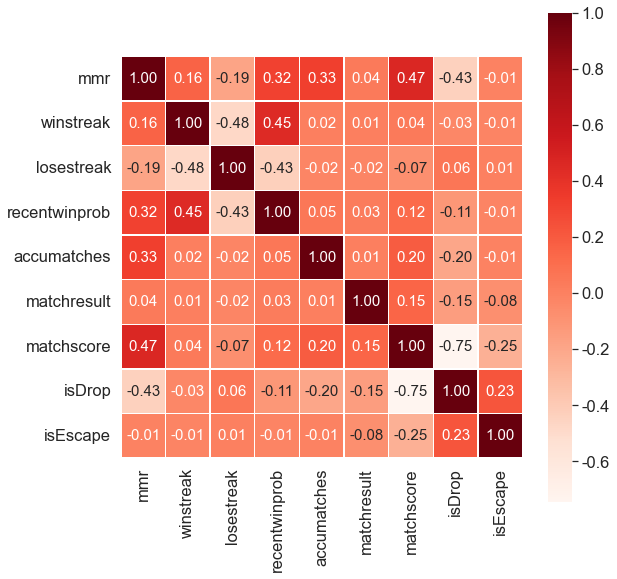

상관행렬 시각화 결과, 변수들 간의 매우 강한 상관관계는 없음을 알 수 있다.
- 예상과는 달리 mmr, accumatches 변수와 matchresult 사이에는 각각 0.04, 0.01로 거의 상관성이 없다. 
  이는 곧 본인의 지표와는 별개로, 어떤 유저와 매칭이 되었느냐에 따라 승패 여부가 갈릴 수 있음을 예측해 볼 수 있다.
  → 팀원에 대한 지표를 추가해야 할 필요가 있음
- 한편, matchscore는 matchresult와 0.15로 해당 매치에서의 플레이 점수가 승패에 영향을 작게나마 미친다고 할 수 있다.
- 또한, isDrop과 matchscore의 상관계수는 -0.75로 강한 음의 상관관계를 갖는다. 이는 매치에서 좋은 퍼포먼스를 보이지 못한
  유저가 주로 기권을 하거나, 기권 자체가 점수에 마이너스로 작용한다고 예상할 수 있다.
-----------------------------------------------------------------------------------------------------------------------
> 위의 분석에 이어 수치형 변수들에 대해 로지스틱 회귀분석을 통해 범주형 타겟변수에 대한 상관성을 확인한 후 
  피처 엔지니어링을 진행한다. 


In [8]:
# 수치형 변수 상관행렬 시각화
num_corr = num_df.corr(method='pearson')
plt.figure(figsize=(len(num_df.columns), len(num_df.columns)))
sns.set(font_scale = 1.5)
hm = sns.heatmap(num_corr, cbar = True, annot = True, square = True, cmap = 'Reds', fmt = '.2f', linewidth=.5, annot_kws ={'size' : 15}, 
                 yticklabels = num_df.columns, xticklabels = num_df.columns )

plt.show()

print("""상관행렬 시각화 결과, 변수들 간의 매우 강한 상관관계는 없음을 알 수 있다.
- 예상과는 달리 mmr, accumatches 변수와 matchresult 사이에는 각각 0.04, 0.01로 거의 상관성이 없다. 
  이는 곧 본인의 지표와는 별개로, 어떤 유저와 매칭이 되었느냐에 따라 승패 여부가 갈릴 수 있음을 예측해 볼 수 있다.
  → 팀원에 대한 지표를 추가해야 할 필요가 있음
- 한편, matchscore는 matchresult와 0.15로 해당 매치에서의 플레이 점수가 승패에 영향을 작게나마 미친다고 할 수 있다.
- 또한, isDrop과 matchscore의 상관계수는 -0.75로 강한 음의 상관관계를 갖는다. 이는 매치에서 좋은 퍼포먼스를 보이지 못한
  유저가 주로 기권을 하거나, 기권 자체가 점수에 마이너스로 작용한다고 예상할 수 있다.
-----------------------------------------------------------------------------------------------------------------------
> 위의 분석에 이어 수치형 변수들에 대해 로지스틱 회귀분석을 통해 범주형 타겟변수에 대한 상관성을 확인한 후 
  피처 엔지니어링을 진행한다. """)

### 1차 모델링

In [9]:
import statsmodels.api as sm

print("""먼저 mmr, accumatches 컬럼과 recentwinprob 등의 컬럼의 단위 차이가 크므로 스케일링을 진행한다. \n또한, isDrop, isEscape 컬럼은 단순 0,1 구분값이므로 범주형 변수로 인식한 후, 로지스틱 회귀분석을 수행한다. 
---------------------------------------------------------------------------------------------------------""")

# 독립변수와 종속변수 분리
X = num_df.drop('matchresult', axis=1)  # 독립변수
y = num_df['matchresult']  # 종속변수

# 수치형 변수와 범주형 변수 분리
numeric_features = X.loc[:,~X.columns.isin(['isDrop', 'isEscape'])]  # 수치형 변수
categorical_features = X.loc[:,['isDrop', 'isEscape']] # 범주형 변수

# 수치형 변수 스케일링
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(numeric_features)
X_numeric_scaled_df = pd.DataFrame(X_numeric_scaled, columns=numeric_features.columns)

# 범주형 변수와 수치형 변수 결합
X_scaled = pd.concat([X_numeric_scaled_df, categorical_features], axis=1)

# 상수 (절편) 추가
X = sm.add_constant(X_scaled)

# 로지스틱 회귀 모델 생성
model = sm.Logit(y, X)

# 모델 피팅
result = model.fit()

# 모델 요약 정보 출력
print(result.summary())

cm_df = pd.DataFrame(result.pred_table())
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
print(cm_df)
print('---------------------------------------------------------------------------------------------------------')
print("""수치형 변수들에 대해 로지스틱 회귀분석 결과, 모든 변수는 승패여부(타겟변수)에 대해 유의미한 것으로 나타났다. 
isEscape, isDrop의 경우 각각 -0.75, -0.42로 강한 음의 상관관계를 보였으며, 나머지는 상관성이 거의 없는 것으로 나타났다. \n또한, 모델의 설명력은 0.02로 매우 낮은 설명력을 보이고 있다. 이에, 피처 엔지니어링을 통해 모델 설명력 및 변수 상관성을 \n개선할 수 있는 새로운 피처를 생성할 필요가 있다.""")

먼저 mmr, accumatches 컬럼과 recentwinprob 등의 컬럼의 단위 차이가 크므로 스케일링을 진행한다. 
또한, isDrop, isEscape 컬럼은 단순 0,1 구분값이므로 범주형 변수로 인식한 후, 로지스틱 회귀분석을 수행한다. 
---------------------------------------------------------------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.677965
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            matchresult   No. Observations:               410384
Model:                          Logit   Df Residuals:                   410375
Method:                           MLE   Df Model:                            8
Date:                Mon, 12 Feb 2024   Pseudo R-squ.:                 0.02190
Time:                        19:26:37   Log-Likelihood:            -2.7823e+05
converged:                       True   LL-Null:                   -2.8446e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   

### 피처 엔지니어링

In [10]:
# IQR 기반 이상값 대체(winstreak, losestreak 변수)
def replace_outliers_with_limits(column):
    column = column.astype(float)
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return np.where(column > upper_limit, upper_limit, np.where(column < lower_limit, lower_limit, column))

# 함수 사용해서 이상치 값 대체
df['winstreak'] = replace_outliers_with_limits(df['winstreak'])
df['losestreak'] = replace_outliers_with_limits(df['losestreak'])
df['recentwinprob'] = replace_outliers_with_limits(df['recentwinprob'])

print(f'winstreak 변수 상한값 : {df["winstreak"].max()} / 하한값 : {df["winstreak"].min()}')
print(f'losestreak 변수 상한값 : {df["losestreak"].max()} / 하한값 : {df["losestreak"].min()}')
print(f'recentwinprob 변수 상한값 : {df["recentwinprob"].max()} / 하한값 : {df["recentwinprob"].min()}')

winstreak 변수 상한값 : 5.0 / 하한값 : 0.0
losestreak 변수 상한값 : 2.5 / 하한값 : 0.0
recentwinprob 변수 상한값 : 0.8999999999999999 / 하한값 : 0.10000000000000009


In [11]:
print(f"""데이터셋에서 매치id의 유니크 수는 {df['matchid'].nunique()}개로, 4대4 매치임을 고려했을 때 총 51298개의 매치에 대한 8명 모두의 데이터가 
들어있다. 이에 matchid, teamid를 기준으로 상대팀과 같은팀을 구분하여 각 팀의 mmr, accumatches 등의 지표를 산출한다. 
추가적으로, winstreak, losestreak 변수를 통해 팀에 연승 or 연패 유저가 있는지, recentwinprob 변수를 통해 
최근 승률이 좋은 팀원이 있는지 나타내는 피처 엔지니어링을 수행한다.""")

# 팀별 mmr 평균
team_mmr = df.groupby(['matchid', 'teamid'])['mmr', 'accumatches'].mean().reset_index()
team_mmr.rename(columns={'mmr': 'team_mmr', 'accumatches' : 'team_accumatches'}, inplace=True)  # 컬럼 이름 변경

# 기존 데이터프레임과 병합
df = df.merge(team_mmr, on=['matchid', 'teamid'], how='left')

데이터셋에서 매치id의 유니크 수는 51298개로, 4대4 매치임을 고려했을 때 총 51298개의 매치에 대한 8명 모두의 데이터가 
들어있다. 이에 matchid, teamid를 기준으로 상대팀과 같은팀을 구분하여 각 팀의 mmr, accumatches 등의 지표를 산출한다. 
추가적으로, winstreak, losestreak 변수를 통해 팀에 연승 or 연패 유저가 있는지, recentwinprob 변수를 통해 
최근 승률이 좋은 팀원이 있는지 나타내는 피처 엔지니어링을 수행한다.


In [12]:
print("""앞선 이상치 대체를 통해 연승 최고치는 5승, 연패 최고치는 2.5패로 대체되었다. 
이에 연승이 5승인 유저는 1, 연패가 2.5인 유저는 -1을 부여하여 팀별 합계를 나타내는 새로운 컬럼을 생성한다.
ex) 팀 내에 5연승 중인 유저가 있을 경우 1, 2.5연패(기존 3연패 이상) 중인 유저가 있을 경우 -1, 각각 해당하는 유저가 한명씩 있을 경우 0""")
max_win = 5
max_lose = 2.5

df['max_win_yn'] = df['winstreak'].apply(lambda x: 1 if x >= max_win else 0)
df['max_lose_yn'] = df['losestreak'].apply(lambda x: -1 if x >= max_lose else 0)

df['max_win_lose_yn'] = df['max_win_yn'] + df['max_lose_yn']

team_yn = df.groupby(['matchid', 'teamid'])['max_win_lose_yn'].sum().reset_index()
team_yn.rename(columns={'max_win_lose_yn': 'team_max_win_lose_yn'}, inplace=True)  # 컬럼 이름 변경

# 기존 데이터프레임과 병합
df = df.merge(team_yn, on=['matchid', 'teamid'], how='left')

앞선 이상치 대체를 통해 연승 최고치는 5승, 연패 최고치는 2.5패로 대체되었다. 
이에 연승이 5승인 유저는 1, 연패가 2.5인 유저는 -1을 부여하여 팀별 합계를 나타내는 새로운 컬럼을 생성한다.
ex) 팀 내에 5연승 중인 유저가 있을 경우 1, 2.5연패(기존 3연패 이상) 중인 유저가 있을 경우 -1, 각각 해당하는 유저가 한명씩 있을 경우 0


In [13]:
print("""recentwinprob 변수는 상위 25%, 하위 25%에 대해 라벨링을 수행한다.
상위 25%인 경우 1, 하위 25%인 경우 -1 값으로 라벨링하여 연승/연패와 마찬가지로 팀별 집계를 구한다.""") 
upper = df['recentwinprob'].quantile(0.75)
lower = df['recentwinprob'].quantile(0.25)
df['prob_yn'] = df['recentwinprob'].apply(lambda x: 1 if x >= upper else (-1 if x <= lower else 0))

team_prob = df.groupby(['matchid', 'teamid'])['prob_yn'].sum().reset_index()
team_prob.rename(columns={'prob_yn': 'team_prob_yn'}, inplace=True)  # 컬럼 이름 변경

# 기존 데이터프레임과 병합
df = df.merge(team_prob, on=['matchid', 'teamid'], how='left')

recentwinprob 변수는 상위 25%, 하위 25%에 대해 라벨링을 수행한다.
상위 25%인 경우 1, 하위 25%인 경우 -1 값으로 라벨링하여 연승/연패와 마찬가지로 팀별 집계를 구한다.


In [14]:
# 팀별 지표를 구했으므로, 개인별 지표 컬럼은 삭제 처리한다.
team_df = df.drop(columns=['prob_yn', 'max_win_yn', 'max_lose_yn', 'max_win_lose_yn', 'winstreak', 'losestreak', 'recentwinprob', 'accumatches', 'mmr'])
team_df

,createdatekst,matchid,accountid,teamid,guildid,tier,itemid,matchresult,matchscore,isDrop,isEscape,team_mmr,team_accumatches,team_max_win_lose_yn,team_prob_yn
0,2022-07-04 00:27:58,m00160017353d8e81,2097311063,1,G69102,gold,1364,0,25,1,0,1780.0,47.25,0,-3
1,2022-07-04 00:27:58,m00160017353d8e81,1560653129,1,없음,gold,1178,0,35,0,0,1780.0,47.25,0,-3
2,2022-07-04 00:27:58,m00160017353d8e81,872694401,1,G5900,platinum,1385,0,39,0,0,1780.0,47.25,0,-3
3,2022-07-04 00:27:58,m00160017353d8e81,84538717,1,G424,bronze,1338,0,0,1,0,1780.0,47.25,0,-3
4,2022-07-04 00:27:58,m00160017353d8e81,142829,2,없음,platinum,1277,1,41,0,0,1890.5,147.50,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410379,2022-06-27 01:47:35,m03c40017117a01f2,621010036,1,G45703,platinum,1337,1,44,0,0,2182.0,835.75,-1,0
410380,2022-06-27 01:47:35,m03c40017117a01f2,1711756742,2,G185081,platinum,1398,0,45,0,0,2073.5,501.00,0,-1
410381,2022-06-27 01:47:35,m03c40017117a01f2,1460484825,2,없음,bronze,1398,0,49,0,0,2073.5,501.00,0,-1
410382,2022-06-27 01:47:35,m03c40017117a01f2,218329344,2,G28051,platinum,1411,0,48,0,0,2073.5,501.00,0,-1


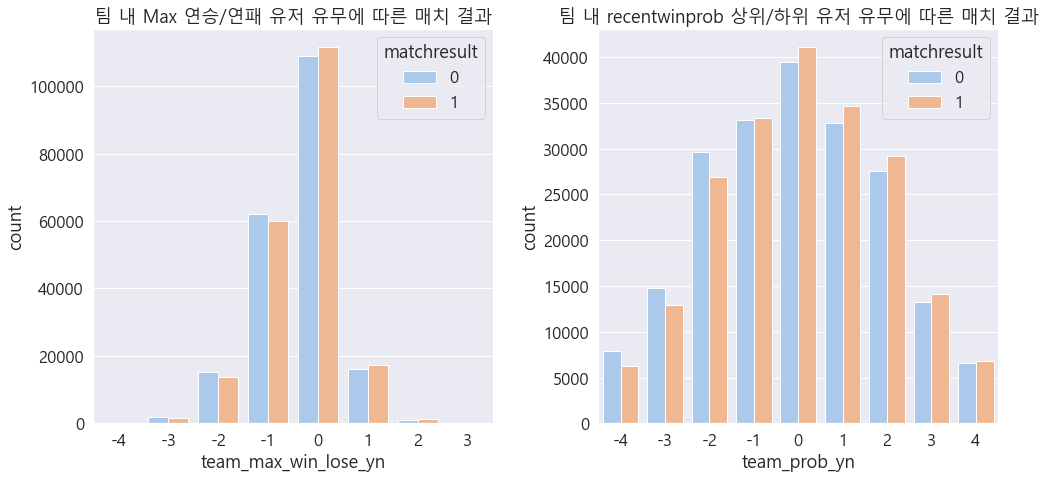

파생변수인 team_max_win_lose_yn 및 team_prob_yn 변수에 대해서, 두 변수 모두 값이 0 미만일 경우 
매치에서 진 비율이 높은 반면, 0 이상일 경우 매치에서 이긴 비율이 더 높음을 알 수 있다. 이에 팀 내에 연승인 유저가 있고, 
최근 승률이 좋은 유저가 있을수록 매치에서 이길 확률이 높아짐을 유추해 볼 수 있다.


In [18]:
sns.set_palette('pastel')
plt.figure(figsize=(15, 7))
ax1 = plt.subplot(121)
sns.countplot(x='team_max_win_lose_yn', data=team_df, hue='matchresult')
ax1.set_title('팀 내 Max 연승/연패 유저 유무에 따른 매치 결과')

ax2 = plt.subplot(122)
sns.countplot(x='team_prob_yn', data=team_df, hue='matchresult')
ax2.set_title('팀 내 recentwinprob 상위/하위 유저 유무에 따른 매치 결과')

plt.tight_layout()
plt.show()

print("""파생변수인 team_max_win_lose_yn 및 team_prob_yn 변수에 대해서, 두 변수 모두 값이 0 미만일 경우 \n매치에서 진 비율이 높은 반면, 0 이상일 경우 매치에서 이긴 비율이 더 높음을 알 수 있다. 이에 팀 내에 연승인 유저가 있고, \n최근 승률이 좋은 유저가 있을수록 매치에서 이길 확률이 높아짐을 유추해 볼 수 있다.""")

In [19]:
# 범주형 변수 고유값 확인
for col in obj_df.columns:
    print(f'{col} 고유값 개수 :',len(obj_df[col].unique()))

print('-----------------------------------------------------------------------------------------------')
print("""범주형 변수에서 고유 식별값에 해당하는 변수들은 unique 값이 매우 많아 시각화에 어려움이 있다. 
이에 범주형 변수 중 중요한 변수로 판단되는 tier에 대해서만 시각화를 진행한다.
이후 guildid, itemid에 대해 빈도수 기준 상위 N값만 추출하여 EDA를 수행한다.""")

matchid 고유값 개수 : 51298
accountid 고유값 개수 : 15191
guildid 고유값 개수 : 3366
tier 고유값 개수 : 7
itemid 고유값 개수 : 286
-----------------------------------------------------------------------------------------------
범주형 변수에서 고유 식별값에 해당하는 변수들은 unique 값이 매우 많아 시각화에 어려움이 있다. 
이에 범주형 변수 중 중요한 변수로 판단되는 tier에 대해서만 시각화를 진행한다.
이후 guildid, itemid에 대해 빈도수 기준 상위 N값만 추출하여 EDA를 수행한다.


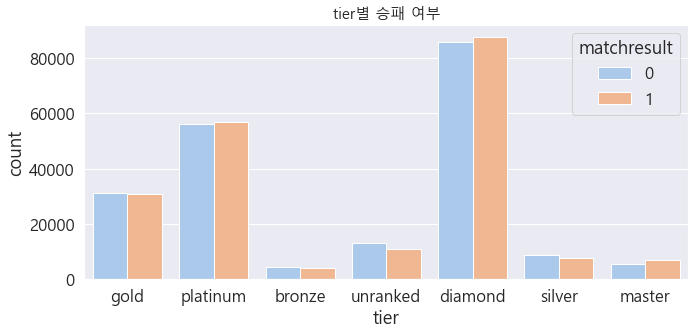

다음은 tier 컬럼에 대한 시각화 결과이다. 
전반적으로 큰 차이는 없지만, 언랭크, 브론즈, 실버는 패배한 비율이 승리한 비율 대비 다소 높으며 
플레티넘, 다이아몬드, 마스터는 반대로 승리한 비율이 더 높은 것을 알 수 있다.
이에 티어에 따라 승패 여부에 유의미한 차이가 있는지 통계 분석을 통해 검정할 필요가 있다. 
이 때, 분석의 편의성을 위해 데이터 내 중복 accountid에 대해서는 독립적인 플레이어로 간주한다.


In [20]:
# tier 컬럼 시각화
plt.figure(figsize=(10, 5))
sns.countplot(data=team_df, x='tier', hue='matchresult')
plt.title('tier별 승패 여부', fontsize=15)
plt.tight_layout()
plt.show()

print("""다음은 tier 컬럼에 대한 시각화 결과이다. 
전반적으로 큰 차이는 없지만, 언랭크, 브론즈, 실버는 패배한 비율이 승리한 비율 대비 다소 높으며 
플레티넘, 다이아몬드, 마스터는 반대로 승리한 비율이 더 높은 것을 알 수 있다.
이에 티어에 따라 승패 여부에 유의미한 차이가 있는지 통계 분석을 통해 검정할 필요가 있다. 
이 때, 분석의 편의성을 위해 데이터 내 중복 accountid에 대해서는 독립적인 플레이어로 간주한다.""")

### 통계검정

In [40]:
# tier, matchresult 크로스탭 생성
tier_list = ['unranked', 'bronze', 'silver', 'gold', 'platinum', 'diamond', 'master']
tier_table = pd.crosstab(team_df['tier'], team_df['matchresult'], values=team_df['matchresult'], aggfunc='count').reindex(tier_list)

# 카이제곱 독립성 검성(검정통계량, 유의확률, 자유도, 기대빈도)
chi, pval, dof, expected = stats.chi2_contingency(observed=tier_table)

# 자유도 계산
t_n = sum(tier_table.sum())
min_dim = min(tier_table.shape)-1
dof = min_dim*(min(tier_table.shape)-1)

# Cramer's V 계산
cramer_v = np.sqrt(chi / (t_n * dof))

# 유의수준 0.05에서의 유의성 검정
print("Chi-Square Statistic:", chi)
print(f"p-value 값은 {pval}로, 유의수준 0.05하에서 tier별 매치 결과에 유의미한 차이가 있다고 할 수 있다.")
print(f"""이에, 고티어로(플레티넘 ~ 마스터) 갈수록 승리할 확률이 유의미하게 증가한다고 유추할 수 있다. 다만, matchresult에 대한 크래머 V 계수는 \n{round(cramer_v,4)}로 낮은 상관성을 보인다고 할 수 있다. 이에 수치형 변수 때와 마찬가지로, 팀 단위의 티어를 산정하고 다시 타겟변수와의 상관성을 분석할 필요가 있다. 실제 교차표(위)와 tier, matchresult가 독립적이라고 가정할 때의 기대빈도 교차표(아래)는 다음과 같다.""")

display(tier_table, pd.DataFrame(expected.round(0)))

Chi-Square Statistic: 444.1349586404036
p-value 값은 8.977809228678202e-93로, 유의수준 0.05하에서 tier별 매치 결과에 유의미한 차이가 있다고 할 수 있다.
이에, 고티어로(플레티넘 ~ 마스터) 갈수록 승리할 확률이 유의미하게 증가한다고 유추할 수 있다. 다만, matchresult에 대한 크래머 V 계수는 
0.0329로 낮은 상관성을 보인다고 할 수 있다. 이에 수치형 변수 때와 마찬가지로, 팀 단위의 티어를 산정하고 다시 타겟변수와의 상관성을 분석할 필요가 있다. 실제 교차표(위)와 tier, matchresult가 독립적이라고 가정할 때의 기대빈도 교차표(아래)는 다음과 같다.


matchresult,0,1
tier,,
unranked,13206,10988
bronze,4594,4176
silver,8733,7763
gold,31059,30859
platinum,56334,56904
diamond,85761,87689
master,5505,6813


,0,1
0,12097.0,12097.0
1,4385.0,4385.0
2,8248.0,8248.0
3,30959.0,30959.0
4,56619.0,56619.0
5,86725.0,86725.0
6,6159.0,6159.0


In [41]:
print("""분석의 단순화를 위해 tier 변수를 세 개의 범주로 구분했습니다. 
- unranked or bronze : -1
- silver or gold or platinum : 0
- diamond or master : 1
이후 match/team id를 기준으로 tier 변수를 더하여 팀별로 티어가 어떻게 분포되어 있는지 라벨링을 수행하였습니다.
ex) 팀에 diamond, master가 각각 1명, bronze, silver가 각각 1명이라면 팀 tier 값은 1""")
# tier 변수를 team 단위로 변환하기 위한 매핑
tier_df = team_df.copy()
tier_map = {'unranked':-1, 'bronze':-1, 'silver':0, 'gold':0, 'platinum':0, 'diamond':1, 'master':1}
tier_df['tier'] = tier_df['tier'].map(tier_map)

team_tier = tier_df.groupby(['matchid', 'teamid'])['tier'].sum().reset_index()
team_tier.rename(columns={'tier': 'team_tier'}, inplace=True)  # 컬럼 이름 변경

# 기존 데이터프레임과 병합
tier_df = tier_df.merge(team_tier, on=['matchid', 'teamid'], how='left')
tier_df.head()

분석의 단순화를 위해 tier 변수를 세 개의 범주로 구분했습니다. 
- unranked or bronze : -1
- silver or gold or platinum : 0
- diamond or master : 1
이후 match/team id를 기준으로 tier 변수를 더하여 팀별로 티어가 어떻게 분포되어 있는지 라벨링을 수행하였습니다.
ex) 팀에 diamond, master가 각각 1명, bronze, silver가 각각 1명이라면 팀 tier 값은 1


,createdatekst,matchid,accountid,teamid,guildid,tier,itemid,matchresult,matchscore,isDrop,isEscape,team_mmr,team_accumatches,team_max_win_lose_yn,team_prob_yn,team_tier
0,2022-07-04 00:27:58,m00160017353d8e81,2097311063,1,G69102,0,1364,0,25,1,0,1780.0,47.25,0,-3,-1
1,2022-07-04 00:27:58,m00160017353d8e81,1560653129,1,없음,0,1178,0,35,0,0,1780.0,47.25,0,-3,-1
2,2022-07-04 00:27:58,m00160017353d8e81,872694401,1,G5900,0,1385,0,39,0,0,1780.0,47.25,0,-3,-1
3,2022-07-04 00:27:58,m00160017353d8e81,84538717,1,G424,-1,1338,0,0,1,0,1780.0,47.25,0,-3,-1
4,2022-07-04 00:27:58,m00160017353d8e81,142829,2,없음,0,1277,1,41,0,0,1890.5,147.50,-1,-1,-1


In [42]:
tier_table = pd.crosstab(tier_df['team_tier'], tier_df['matchresult'], 
                         values=team_df['matchresult'], aggfunc='count').reindex(np.arange(-4,5))
display(tier_table)
# 카이제곱 독립성 검성(검정통계량, 유의확률, 자유도, 기대빈도)
chi, pval, dof, expected = stats.chi2_contingency(observed=tier_table)

# 자유도 계산
t_n = sum(tier_table.sum())
min_dim = min(tier_table.shape)-1
dof = min_dim*(min(tier_table.shape)-1)

# Cramer's V 계산
cramer_v = np.sqrt(chi / (t_n * dof))

# 유의수준 0.05에서의 유의성 검정
print("Chi-Square Statistic:", chi)
print('p-value:', pval)
print('크래머 V 계수:', cramer_v)

print('-----------------------------------------------------------------------------------------------')
print(f"""카이제곱 검정 및 크래머 V 계수 출력 결과, p-value는 {pval}로 여전히 통계적으로 유의하지만,
크래머 V 계수는 {round(cramer_v,4)}로, 매치 결과에 대해 개인별 Tier 변수보다 더 개선된 것을 알 수 있습니다.
이에, 기존변수인 tier 변수를 삭제하고 파생변수인 team_tier 변수를 모델에 적용하겠습니다.""")

matchresult,0,1
team_tier,,
-4,196,60
-3,1040,388
-2,4120,2604
-1,14032,11828
0,34976,33176
1,49660,50680
2,48568,50032
3,37156,40648
4,15444,15776


Chi-Square Statistic: 1139.4890119086554
p-value: 1.1331383605266663e-240
크래머 V 계수: 0.05269384149213023
-----------------------------------------------------------------------------------------------
카이제곱 검정 및 크래머 V 계수 출력 결과, p-value는 1.1331383605266663e-240로 여전히 통계적으로 유의하지만,
크래머 V 계수는 0.0527로, 매치 결과에 대해 개인별 Tier 변수보다 더 개선된 것을 알 수 있습니다.
이에, 기존변수인 tier 변수를 삭제하고 파생변수인 team_tier 변수를 모델에 적용하겠습니다.


In [43]:
# tier 컬럼 삭제
df3 = tier_df.drop(columns=['tier']).copy()

In [44]:
print('길드 ID :',len(df3['guildid'].unique()))
print('아이템 ID :',len(df3['itemid'].unique()))

print("""길드, 아이템의 경우 고유값이 매우 많다보니 추후 모델링에서 설명 변수에 적합하지 않을 수 있습니다. 
최빈수를 기준으로 상위 N개의 값을 추출한 뒤 승/패에 유의미한 차이가 있는지 확인해보았습니다.
(guildid와 itemid는 팀 별로 그룹화 할 수 없으므로, 각 행을 기준으로 분석 수행)""")

print('-----------------------------------------------------------------------------------------------')
print('최빈값 기준 상위 5개 길드의 승패수')
for guildid, count in df3['guildid'].value_counts().head(5).items():
    print(df3[df3['guildid'] == guildid]['matchresult'].value_counts())
    
print('최빈값 기준 상위 5개 아이템의 승패수')    
for itemid, count in df3['itemid'].value_counts().head(5).items():
    print(df3[df3['itemid'] == itemid]['matchresult'].value_counts())

길드 ID : 3366
아이템 ID : 286
길드, 아이템의 경우 고유값이 매우 많다보니 추후 모델링에서 설명 변수에 적합하지 않을 수 있습니다. 
최빈수를 기준으로 상위 N개의 값을 추출한 뒤 승/패에 유의미한 차이가 있는지 확인해보았습니다.
(guildid와 itemid는 팀 별로 그룹화 할 수 없으므로, 각 행을 기준으로 분석 수행)
-----------------------------------------------------------------------------------------------
최빈값 기준 상위 5개 길드의 승패수
0    117132
1    115825
Name: matchresult, dtype: int64
1    919
0    895
Name: matchresult, dtype: int64
0    858
1    783
Name: matchresult, dtype: int64
1    677
0    604
Name: matchresult, dtype: int64
1    589
0    554
Name: matchresult, dtype: int64
최빈값 기준 상위 5개 아이템의 승패수
1    45852
0    43595
Name: matchresult, dtype: int64
0    25396
1    25024
Name: matchresult, dtype: int64
1    19990
0    19832
Name: matchresult, dtype: int64
1    13843
0    13450
Name: matchresult, dtype: int64
1    12129
0    11874
Name: matchresult, dtype: int64


In [45]:
# guildid, itemid별로 빈도수 기준 상위 5개의 행만 추출하여 분석
guild5 = [i for i in df3['guildid'].value_counts().head(5).index]
item5 = [i for i in df3['itemid'].value_counts().head(5).index]

guild5_df = df3[df3['guildid'].isin(guild5)][['guildid', 'matchresult','matchid']]
item5_df = df3[df3['itemid'].isin(item5)][['itemid', 'matchresult','matchid']]

In [46]:
guild_table = pd.crosstab(guild5_df['guildid'], guild5_df['matchresult'], values=guild5_df['matchid'], aggfunc='count')
item_table = pd.crosstab(item5_df['itemid'], item5_df['matchresult'], values=item5_df['matchid'], aggfunc='count')

display(guild_table)
display(item_table)

# guildid 카이제곱 검정 수행
g_chi, g_pval, g_dof, g_expected = stats.chi2_contingency(observed=guild_table)

# 자유도 계산
g_n = sum(tier_table.sum())
min_dim = min(guild_table.shape)-1
dof = min_dim*(min(guild_table.shape)-1)

# Cramer's V 계산
g_cramer_v = np.sqrt(g_chi / (g_n * dof))

# itemid 카이제곱 검정 수행
i_chi, i_pval, i_dof, i_expected = stats.chi2_contingency(observed=item_table)
# 자유도 계산
i_n = sum(tier_table.sum())
min_dim = min(item_table.shape)-1
dof = min_dim*(min(item_table.shape)-1)

# Cramer's V 계산
i_cramer_v = np.sqrt(i_chi / (i_n * dof))

# guildid 카이제곱 검정 결과
print('<길드 별 승패 여부에 대한 카이제곱 검정')
print("Chi-Square Statistic:", g_chi)
print(f"""p-value 값은 {g_pval}로, 유의수준 0.05하에서 길드별 매치 결과에 유의미한 차이가 있다고 할 수 있습니다.
다만, 길드ID와 매치 결과 간의 크래머 V 상관계수는 {round(g_cramer_v,4)}로, 관련성이 매우 낮다고 볼 수 있습니다. 
또한, 해당 검정은 빈도수 기준 상위 5개의 길드값만 추출 후 검정한 결과이기 때문에 신뢰성이 높다고 할 수 없습니다.""")
print('-----------------------------------------------------------------------------------------------')

# itemid 카이제곱 검정 결과
print('<아이템 별 승패 여부에 대한 카이제곱 검정>')
print("Chi-Square Statistic:", i_chi)
print(f"""p-value 값은 {i_pval}로, 유의수준 0.05하에서 아이템별 매치 결과에 유의미한 차이가 있다고 할 수 있습니다.
그러나 아이템ID와 매치 결과 간의 크래머 V 상관계수는 {i_cramer_v}로, 관련성이 낮다고 볼 수 있습니다. 
아이템ID 또한 빈도수 기준 상위 5개만 추출한 결과이기 때문에 신뢰성이 높다고 할 수 없습니다.
다만, 아이템ID는 분명히 게임 내 영향력이 큰 요소이고 전체 {len(df)}개 데이터중 유니크 값이 {df['itemid'].nunique()} 밖에 되지 않기 때문에 \n유저들이 승리를 위해 특정 아이템들에 집중하고 있음을 예상할 수 있습니다.
이에 itemid별 target 값의 평균값으로 대체하는 target encoding을 수행한 후, 모델링 변수로 활용해 보겠습니다.
""")

matchresult,0,1
guildid,,
G179296,895,919
G2350,604,677
G23565,554,589
G844,858,783
없음,117132,115825


matchresult,0,1
itemid,,
1357,13450,13843
1385,11874,12129
1387,19832,19990
1398,25396,25024
1401,43595,45852


<길드 별 승패 여부에 대한 카이제곱 검정
Chi-Square Statistic: 9.768106056106753
p-value 값은 0.044520424699036124로, 유의수준 0.05하에서 길드별 매치 결과에 유의미한 차이가 있다고 할 수 있습니다.
다만, 길드ID와 매치 결과 간의 크래머 V 상관계수는 0.0049로, 관련성이 매우 낮다고 볼 수 있습니다. 
또한, 해당 검정은 빈도수 기준 상위 5개의 길드값만 추출 후 검정한 결과이기 때문에 신뢰성이 높다고 할 수 없습니다.
-----------------------------------------------------------------------------------------------
<아이템 별 승패 여부에 대한 카이제곱 검정>
Chi-Square Statistic: 37.344578429055055
p-value 값은 1.529617100653591e-07로, 유의수준 0.05하에서 아이템별 매치 결과에 유의미한 차이가 있다고 할 수 있습니다.
그러나 아이템ID와 매치 결과 간의 크래머 V 상관계수는 0.009539345323336458로, 관련성이 낮다고 볼 수 있습니다. 
아이템ID 또한 빈도수 기준 상위 5개만 추출한 결과이기 때문에 신뢰성이 높다고 할 수 없습니다.
다만, 아이템ID는 분명히 게임 내 영향력이 큰 요소이고 전체 410384개 데이터중 유니크 값이 286 밖에 되지 않기 때문에 
유저들이 승리를 위해 특정 아이템들에 집중하고 있음을 예상할 수 있습니다.
이에 itemid별 target 값의 평균값으로 대체하는 target encoding을 수행한 후, 모델링 변수로 활용해 보겠습니다.



In [24]:
df4 = df3.copy()

# 범주별 타겟 변수 평균 계산
target_means = df4.groupby('itemid')['matchresult'].mean().to_dict()

# 타겟 인코딩 적용
df4['itemid'] = df4['itemid'].map(target_means)
df4.head()

,createdatekst,matchid,accountid,teamid,guildid,itemid,matchresult,matchscore,isDrop,isEscape,team_mmr,team_accumatches,team_max_win_lose_yn,team_prob_yn,team_tier
0,2022-07-04 00:27:58,m00160017353d8e81,2097311063,1,G69102,0.486789,0,25,1,0,1780.0,47.25,0,-3,-1
1,2022-07-04 00:27:58,m00160017353d8e81,1560653129,1,없음,0.498900,0,35,0,0,1780.0,47.25,0,-3,-1
2,2022-07-04 00:27:58,m00160017353d8e81,872694401,1,G5900,0.505312,0,39,0,0,1780.0,47.25,0,-3,-1
3,2022-07-04 00:27:58,m00160017353d8e81,84538717,1,G424,0.486111,0,0,1,0,1780.0,47.25,0,-3,-1
4,2022-07-04 00:27:58,m00160017353d8e81,142829,2,없음,0.504664,1,41,0,0,1890.5,147.50,-1,-1,-1


현재까지 완성된 데이터프레임 및 변수를 살펴보면 다음과 같습니다. 데이터 기록 시각, 게임 식별자 등과 같은 타겟 변수와 무관한 변수를 제외한 나머지 변수를 활용해 모델링을 진행하였습니다.(isDrop, isEscape 제외)
- createdatekst : 데이터 기록 시각 
- matchid : 게임 식별자
- accountid : 유저 식별자
- teamid : 팀 번호
- guildid : 가입 길드 식별자
- itemid : 장착 아이템별 Target Encoding 값
- matchresult :게임 결과
- matchscore : 게임 점수
- isDrop : 게임 기권 여부
- isEscape : 게임 탈주 여부
- team_mmr : 팀 평균 mmr
- team_accumatches : 팀 평균 누적게임 수
- team_max_win_lose_yn : 팀 내 다연승/다연패 유저 유무에 따른 식별자(다연승 : +1, 다연패 : -1)
- team_prob_yn : 팀 내 최근 승률 상위/하위 유저 유무에 따른 식별자(상위 : +1, 하위 : -1)
- team_tier : 팀 단위 티어 식별값(unranked-bronze : -1, silver-platinum : 0, diamond-master : +1)

In [98]:
fin_df = df4.copy()

X = fin_df.drop(['matchid', 'accountid', 'createdatekst', 'teamid', 'guildid', 'matchresult', 'isDrop', 'isEscape', 'matchscore'], axis=1)
num_x = X.drop(['team_max_win_lose_yn', 'team_prob_yn', 'team_tier'], axis=1)
obj_x = X.loc[:,~X.columns.isin(num_x)]
Y = fin_df['matchresult']

# 수치형 변수 스케일링
scaler = StandardScaler()
scaled_num_x = scaler.fit_transform(num_x)
scaled_num_x_df = pd.DataFrame(scaled_num_x, columns=num_x.columns)

# 범주형 변수와 수치형 변수 결합
X_scaled = pd.concat([scaled_num_x_df, obj_x], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, Y, 
                                                    test_size=0.25, stratify=y, 
                                                    random_state=123456)

In [81]:
# 테스트 데이터 호출
test_df = pd.read_csv('test_data.csv')
# itemid 변수 인코딩
test_df['itemid'] = test_df['itemid'].map(target_means)

# team_tier 변수 생성
test_tier = {'unranked':-1, 'bronze':-1, 'silver':0, 'gold':0, 'platinum':0, 'diamond':1, 'master':1}
test_df['tier'] = test_df['tier'].map(test_tier)
test_team_tier = test_df.groupby(['matchid', 'teamid'])['tier'].sum().reset_index()
test_team_tier.rename(columns={'tier': 'team_tier'}, inplace=True)  # 컬럼 이름 변경
test_df = test_df.merge(test_team_tier, on=['matchid', 'teamid'], how='left')

# team_mmr, team_accumatches 변수 생성
test_team_mmr = test_df.groupby(['matchid', 'teamid'])['mmr', 'accumatches'].mean().reset_index()
test_team_mmr.rename(columns={'mmr': 'team_mmr', 'accumatches' : 'team_accumatches'}, inplace=True)  # 컬럼 이름 변경
test_df = test_df.merge(test_team_mmr, on=['matchid', 'teamid'], how='left')

# team_prob_yn 변수 생성
test_upper = test_df['recentwinprob'].quantile(0.75)
test_lower = test_df['recentwinprob'].quantile(0.25)
test_df['prob_yn'] = test_df['recentwinprob'].apply(lambda x: 1 if x >= upper else (-1 if x <= lower else 0))

test_team_prob = test_df.groupby(['matchid', 'teamid'])['prob_yn'].sum().reset_index()
test_team_prob.rename(columns={'prob_yn': 'team_prob_yn'}, inplace=True)  # 컬럼 이름 변경
test_df = test_df.merge(test_team_prob, on=['matchid', 'teamid'], how='left')

# team_max_win_lose_yn 변수 생성
test_df['max_win_yn'] = test_df['winstreak'].apply(lambda x: 1 if x >= max_win else 0)
test_df['max_lose_yn'] = test_df['losestreak'].apply(lambda x: -1 if x >= max_lose else 0)
test_df['max_win_lose_yn'] = test_df['max_win_yn'] + test_df['max_lose_yn']

test_team_yn = test_df.groupby(['matchid', 'teamid'])['max_win_lose_yn'].sum().reset_index()
test_team_yn.rename(columns={'max_win_lose_yn': 'team_max_win_lose_yn'}, inplace=True)  # 컬럼 이름 변경
test_df = test_df.merge(test_team_yn, on=['matchid', 'teamid'], how='left')

In [82]:
test_df = test_df.drop(columns=['prob_yn', 'max_win_yn', 'max_lose_yn', 'max_win_lose_yn', 'winstreak', 'losestreak', 'recentwinprob', 'accumatches', 'mmr', 'tier'])

test_X = test_df.drop(['matchid', 'accountid', 'createdatekst', 'teamid', 'guildid'], axis=1)
test_num_x = test_X.drop(['team_max_win_lose_yn', 'team_prob_yn', 'team_tier'], axis=1)
test_obj_x = test_X.loc[:,~test_X.columns.isin(test_num_x)]

# 수치형 변수 스케일링
test_scaled_num_x = scaler.fit_transform(test_num_x)
test_scaled_num_x_df = pd.DataFrame(test_scaled_num_x, columns=test_num_x.columns)

# 범주형 변수와 수치형 변수 결합
test_X_scaled = pd.concat([test_scaled_num_x_df, test_obj_x], axis=1)

### 2차 모델링

Optimization terminated successfully.
         Current function value: 0.690429
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            matchresult   No. Observations:               410384
Model:                          Logit   Df Residuals:                   410357
Method:                           MLE   Df Model:                           26
Date:                Thu, 02 Nov 2023   Pseudo R-squ.:                0.003922
Time:                        22:50:54   Log-Likelihood:            -2.8334e+05
converged:                       True   LL-Null:                   -2.8446e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -1.4361      0.233     -6.165      0.

Text(0.5, 0, '변수 중요도')

로지스틱 회귀분석 결과 모델 설명력은 0.0039로 매우 낮습니다.
파생변수에서의 몇가지 케이스를 제외하면 대부분의 변수는 유의미하다고 볼 수 있습니다.
모델 설명력이 매우 낮기 때문에, 추가적인 분류 모델을 수행하여 적합한 모델을 선정합니다.


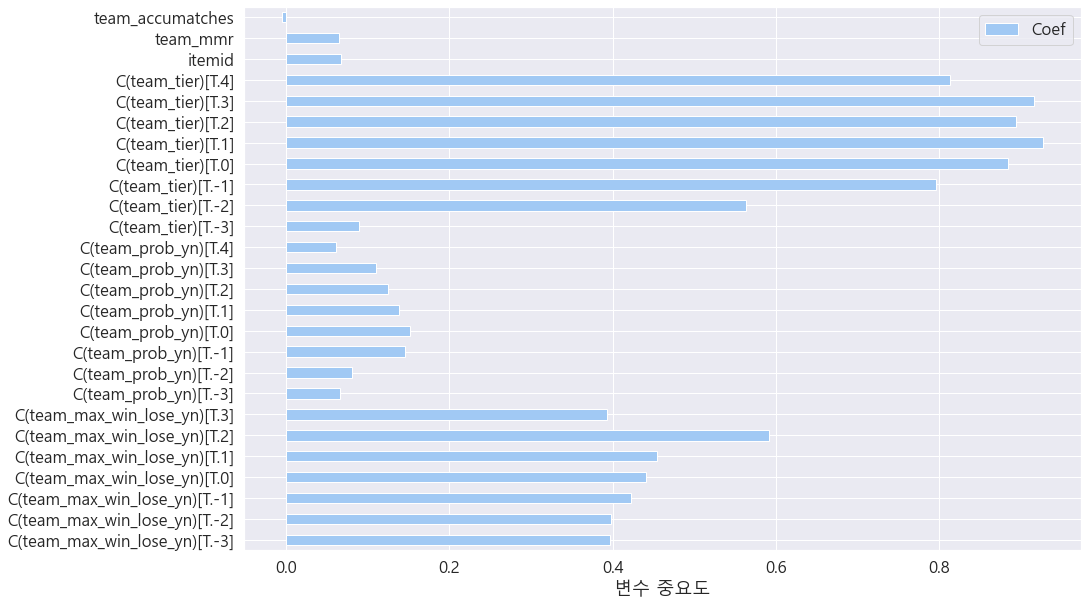

In [124]:
from statsmodels.api import Logit

Y_X_scaled = pd.concat([Y, X_scaled], axis=1)
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula("""matchresult ~ C(team_max_win_lose_yn) + C(team_prob_yn) + C(team_tier) + itemid + team_mmr + team_accumatches""", Y_X_scaled)

log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

df_logistic_coef = pd.DataFrame({'Coef' : log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y='Coef', figsize=(15,10))
plt.xlabel('변수 중요도')

print("""로지스틱 회귀분석 결과 모델 설명력은 0.0039로 매우 낮습니다.
파생변수에서의 몇가지 케이스를 제외하면 대부분의 변수는 유의미하다고 볼 수 있습니다.
모델 설명력이 매우 낮기 때문에, 추가적인 분류 모델을 수행하여 적합한 모델을 선정합니다.""")

의사결정나무모델 Score(학습데이터) : 0.5240750126710593


<Figure size 1440x1080 with 0 Axes>

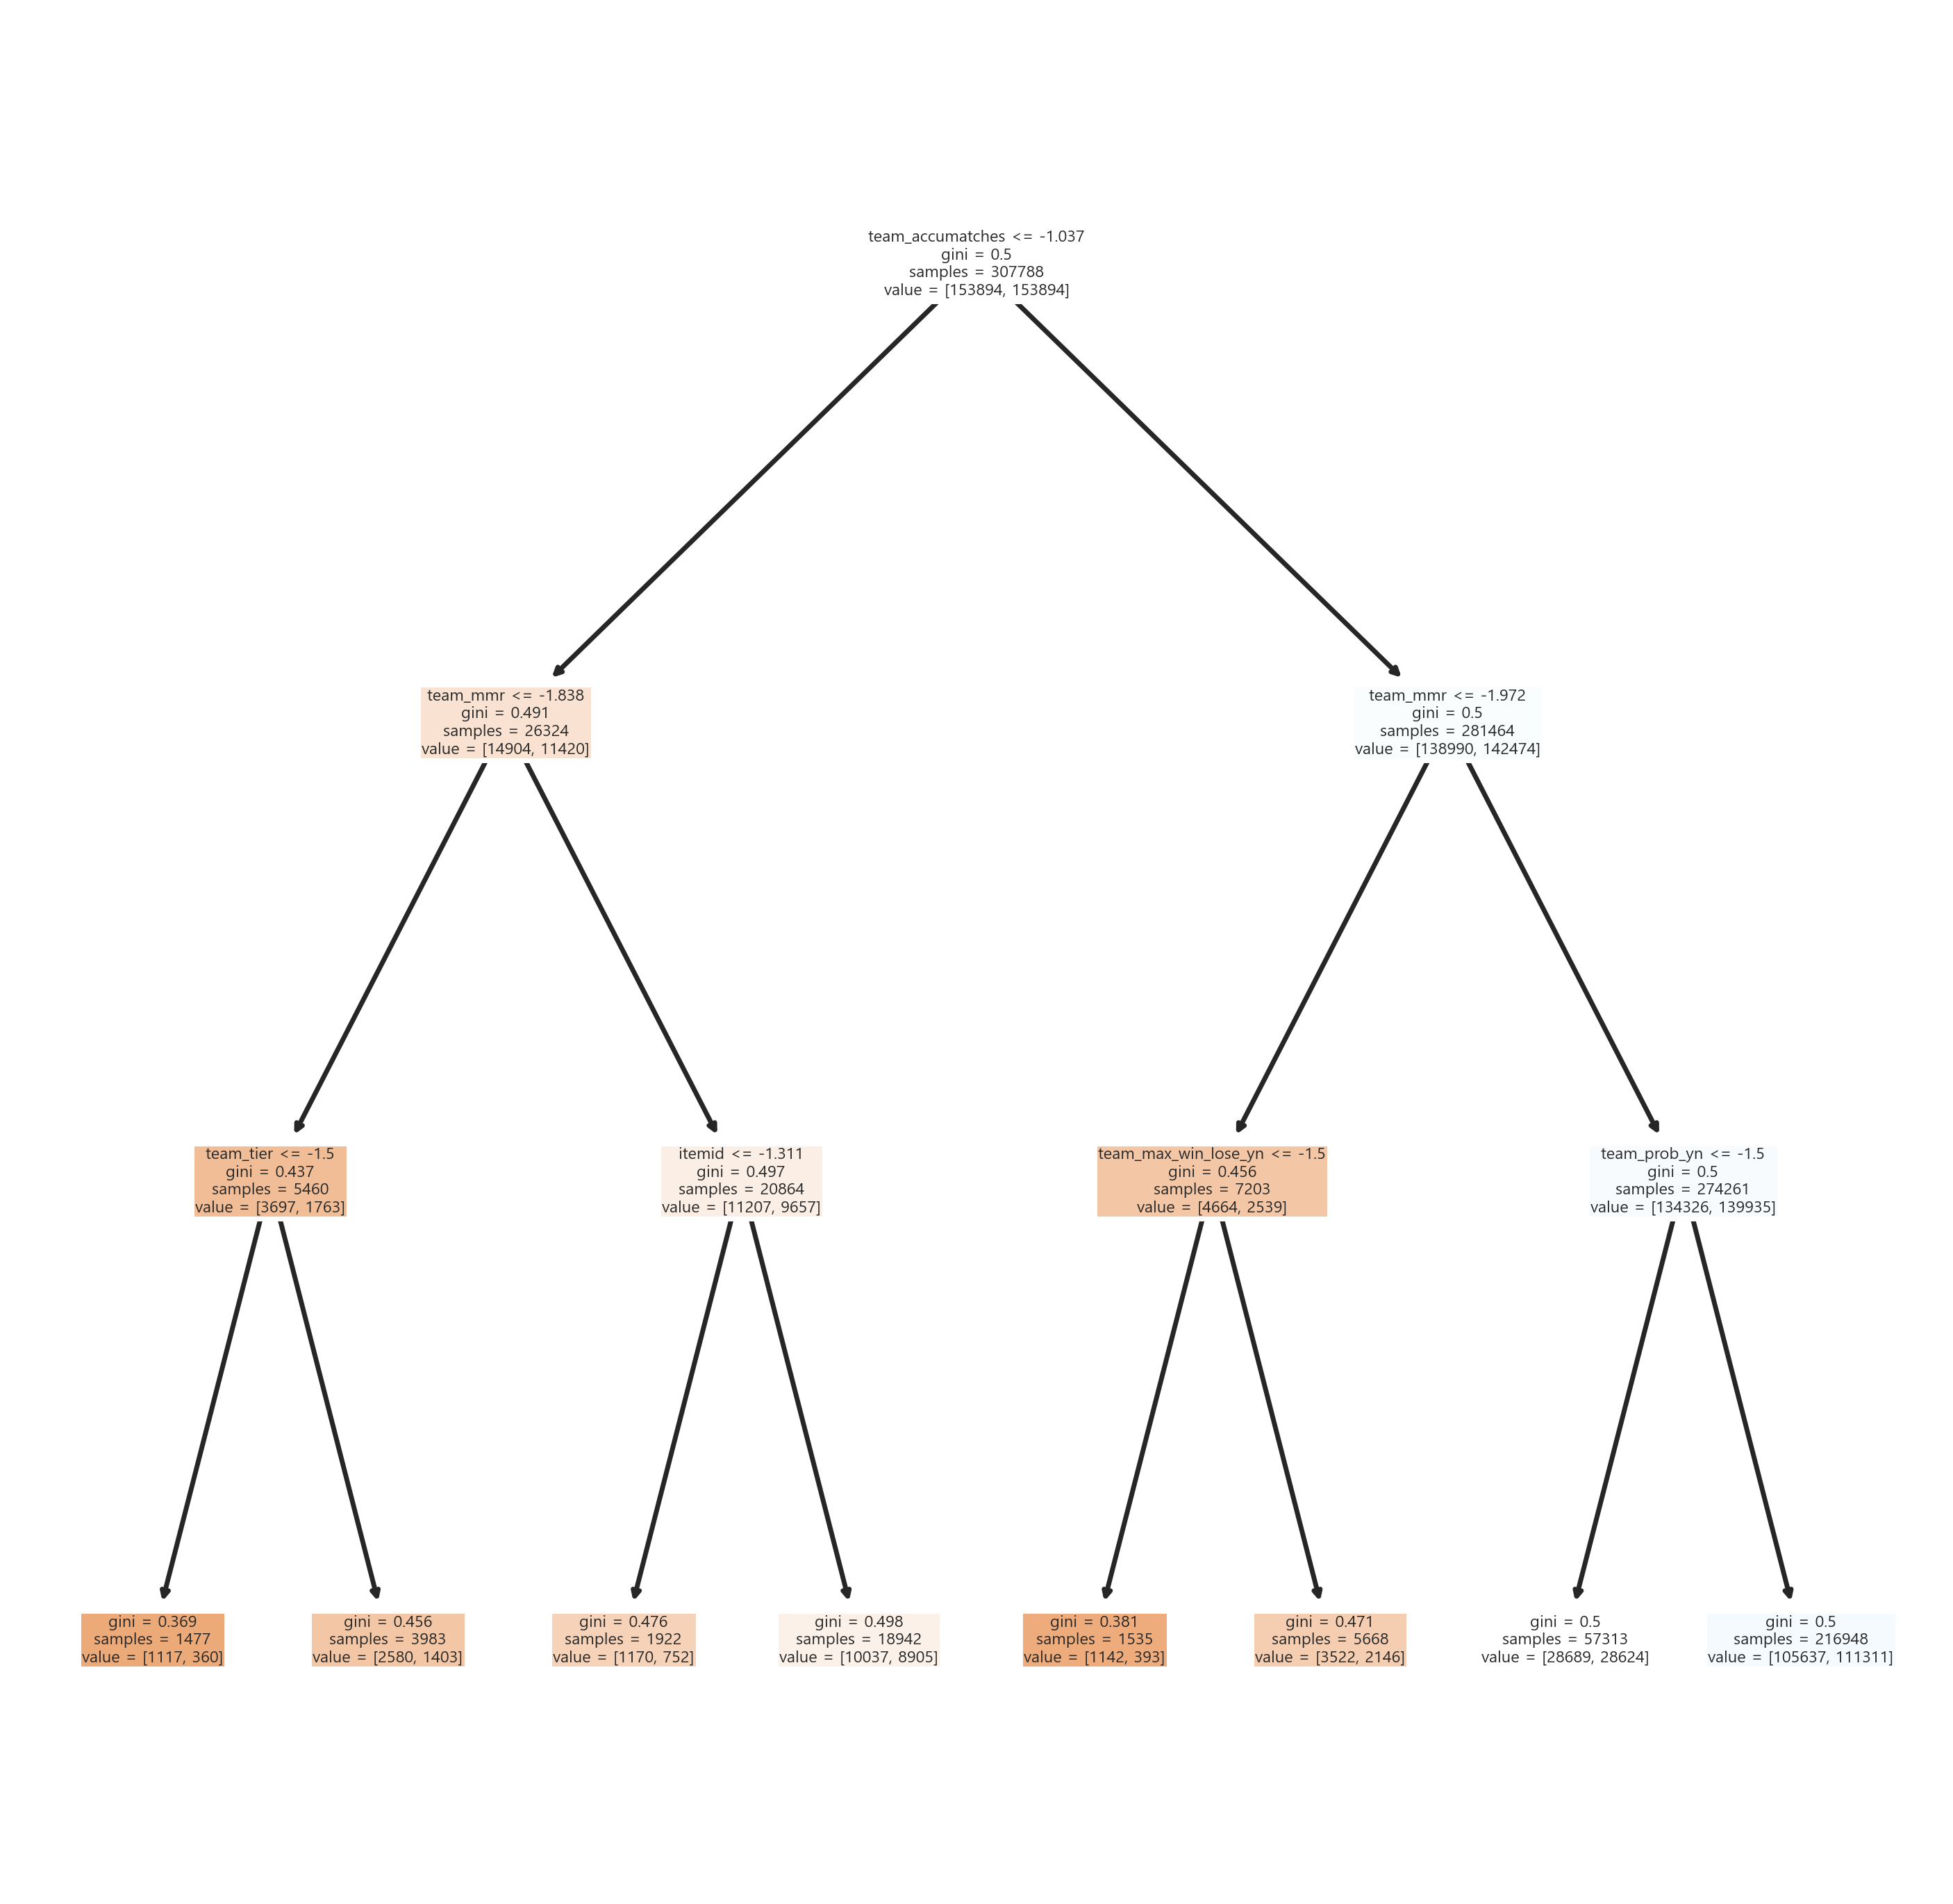

In [99]:
# 의사결정나무 모델링
tree_model = DecisionTreeClassifier(random_state=1234,  min_samples_leaf=10, min_samples_split=10, max_depth = 3, max_features='sqrt')
tree_model.fit(X_train, y_train)
plt.figure(figsize=(20,15))
v_feature_name = X_scaled.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (7, 7), dpi=500)
plot_tree(tree_model, feature_names = v_feature_name, filled = True);
print(f'의사결정나무모델 Score(학습데이터) : {tree_model.score(X_val, y_val)}')

In [104]:
# 신경망 모델링
nn_final = MLPClassifier(batch_size = 120, solver = 'adam', hidden_layer_sizes = (20,20), random_state = 1234, activation = 'logistic')
nn_final.fit(X_train, y_train)

print('Accuracy on training set : {}'.format(nn_final.score(X_val, y_val)))

Accuracy on training set : 0.5303228196031035


In [105]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=20, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

print(f'rf model accuracy_score : {rf.score(X_val, y_val)}')

rf model accuracy_score : 0.8094272681196149


In [106]:
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

print(f'xgb model accuracy_score : {xgb_model.score(X_val, y_val)}') #정확도 계산

[22:31:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgb model accuracy_score : 0.5780537252914344


In [130]:
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# CatBoost 모델 초기화 및 학습
cb = CatBoostClassifier(iterations=500, depth=10, learning_rate=0.05, loss_function='Logloss', verbose=100)
cb.fit(X_train, y_train)

print(f"catboost model accuracy_score : {cb.score(X_val, y_val)}")
print("""catboost 모델의 검증 데이터 정확도는 약 59.5%로, 앞선 3개의 모델 대비 정확도가 높습니다.
이에 catboost 모델을 통해 테스트 데이터 예측을 수행하였습니다.""")

0:	learn: 0.6927352	total: 130ms	remaining: 1m 4s
100:	learn: 0.6811883	total: 9.53s	remaining: 37.7s
200:	learn: 0.6745195	total: 18.9s	remaining: 28.1s
300:	learn: 0.6674463	total: 28.5s	remaining: 18.8s
400:	learn: 0.6600158	total: 38.1s	remaining: 9.42s
499:	learn: 0.6532567	total: 47.3s	remaining: 0us


catboost model accuracy_score : 0.5946333190377793
catboost 모델의 검증 데이터 정확도는 약 59.5%로, 앞선 3개의 모델 대비 정확도가 높습니다.
이에 catboost 모델을 통해 테스트 데이터 예측을 수행하였습니다.


In [131]:
y_val_pred = cb.predict(X_val)
print(classification_report(y_val, y_val_pred, digits=3))
print("""다음은 catbooost 모델의 검증 데이터에 대한 혼동행렬입니다.
Precision(정밀도)는 양성 클래스(1)로 예측한 케이스 중 실제 양성 클래스인 비율을 나타냅니다. 1로 예측한 경우 중 실제로 양성인 경우의 비율은 0.585이며, 이것은 모델이 양성 클래스를 어느 정도 정확하게 예측한다는 것을 의미합니다.

Recall(재현율)은 실제 양성 클래스 중 모델이 양성 클래스로 올바르게 예측한 비율을 나타냅니다. 실제 양성 중에서 1로 정확하게 예측한 비율은 0.651이며, 이것은 모델이 양성 클래스를 얼마나 잘 찾아내는지를 나타냅니다.

F1-score(F1 점수)는 정밀도와 재현율의 조화 평균을 나타내며, 두 지표 간의 균형을 제공합니다. F1 점수는 0.616로 중간 정도의 성능을 보여주며, 모델이 정밀도와 재현율 사이의 균형을 유지하는 것을 나타냅니다.

Support는 각 클래스(0과 1)의 샘플 수를 나타내며, 이 경우 0과 1 클래스 모두 51298개의 샘플이 있습니다.
Accuracy(정확도)는 전체 예측 중 올바르게 분류된 비율을 나타냅니다. 이 모델은 약 59.5%의 정확도를 가집니다.""")

y_pred = cb.predict(test_X_scaled)
y_pred = pd.DataFrame(y_pred, columns={'matchresult'})
y_pred.to_csv('pred_matchresult.csv', index=False)

              precision    recall  f1-score   support

           0      0.607     0.538     0.570     51298
           1      0.585     0.651     0.616     51298

    accuracy                          0.595    102596
   macro avg      0.596     0.595     0.593    102596
weighted avg      0.596     0.595     0.593    102596

다음은 catbooost 모델의 검증 데이터에 대한 혼동행렬입니다.
Precision(정밀도)는 양성 클래스(1)로 예측한 케이스 중 실제 양성 클래스인 비율을 나타냅니다. 1로 예측한 경우 중 실제로 양성인 경우의 비율은 0.585이며, 이것은 모델이 양성 클래스를 어느 정도 정확하게 예측한다는 것을 의미합니다.

Recall(재현율)은 실제 양성 클래스 중 모델이 양성 클래스로 올바르게 예측한 비율을 나타냅니다. 실제 양성 중에서 1로 정확하게 예측한 비율은 0.651이며, 이것은 모델이 양성 클래스를 얼마나 잘 찾아내는지를 나타냅니다.

F1-score(F1 점수)는 정밀도와 재현율의 조화 평균을 나타내며, 두 지표 간의 균형을 제공합니다. F1 점수는 0.616로 중간 정도의 성능을 보여주며, 모델이 정밀도와 재현율 사이의 균형을 유지하는 것을 나타냅니다.

Support는 각 클래스(0과 1)의 샘플 수를 나타내며, 이 경우 0과 1 클래스 모두 51298개의 샘플이 있습니다.
Accuracy(정확도)는 전체 예측 중 올바르게 분류된 비율을 나타냅니다. 이 모델은 약 59.5%의 정확도를 가집니다.


다음은 모델링 한 모델에서의 변수 중요도입니다. 


<Figure size 720x360 with 0 Axes>

 1)itemid                        0.378833
 2)team_mmr                      0.367853
 3)team_accumatches              0.112754
 4)team_max_win_lose_yn          0.062260
 5)team_prob_yn                  0.039653
 6)team_tier                     0.038647


Text(0.5, 1.0, '랜덤포레스트 Feature Importances')

<BarContainer object of 6 artists>

([<matplotlib.axis.XTick at 0x21188c61ac0>,
 [Text(0, 0, 'itemid'),
  Text(0, 0, 'team_mmr'),
  Text(0, 0, 'team_accumatches'),
  Text(0, 0, 'team_max_win_lose_yn'),
  Text(0, 0, 'team_prob_yn'),
  Text(0, 0, 'team_tier')])

(-1.0, 6.0)

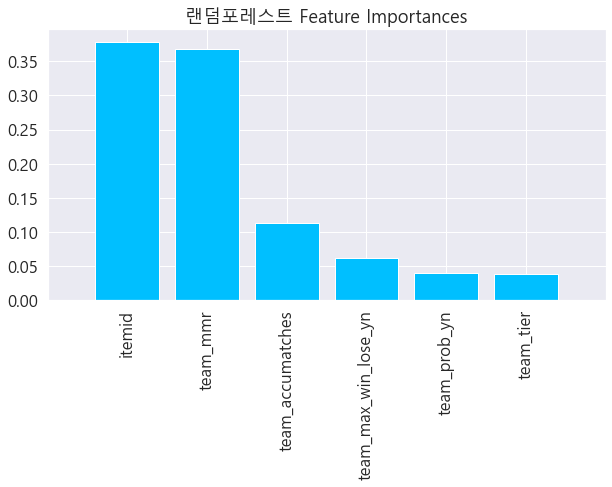

<Figure size 936x360 with 0 Axes>

Text(0.5, 0, 'Feature Importance')

Text(0.5, 1.0, 'Catboost Feature Importances')

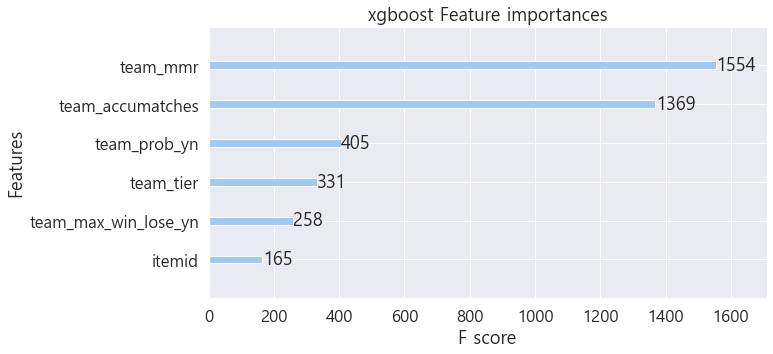

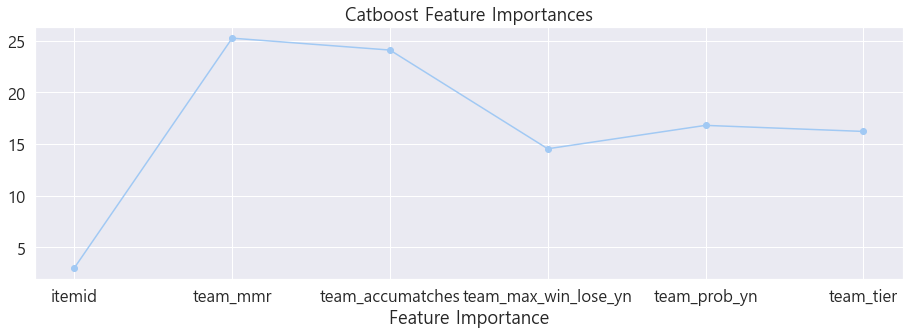

In [132]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
print('다음은 모델링 한 모델에서의 변수 중요도입니다. ')
# 랜덤포레스트 변수 중요도
plt.figure(figsize=(10,5))

features_label = X_scaled.columns
rf_importances = rf.feature_importances_
indices = np.argsort(rf_importances)[::-1]
for i in range(X.shape[1]):
     print('%2d)%-*s%f'%(i+1, 30, features_label[i], rf_importances[indices[i]]))
plt.title('랜덤포레스트 Feature Importances')
plt.bar(range(X.shape[1]), rf_importances[indices], color='deepskyblue', align='center')
plt.xticks(range(X.shape[1]), features_label, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# xgboost 변수 중요도
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgb_model, title='xgboost Feature importances', ax=ax)

# catboost 변수 중요도
# 중요도를 내림차순으로 정렬합니다.
feature_names = X_train.columns  # X_train은 학습 데이터의 피처들을 나타냅니다.
feature_importance = cb.get_feature_importance()
sorted_idx = feature_importance.argsort()[::-1]
plt.figure(figsize=(13, 5))
plt.plot(feature_names, feature_importance, marker='o', linestyle='-')
plt.xlabel('Feature Importance')
plt.title('Catboost Feature Importances')
plt.tight_layout()
plt.show()